In [24]:
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc, mean_squared_error, mean_absolute_error, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

import numpy as np

pd.options.display.float_format = '{:.2f}'.format
random.seed(42)
np.random.seed(42)

In [2]:
df = pd.read_csv('modified_train.csv', index_col=0)

In [3]:
df['ctws'].fillna('', inplace=True)

/var/folders/v9/61pbr9j16zx7f0dxmvmrh7500000gn/T/ipykernel_30299/3334934365.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ctws'].fillna('', inplace=True)


In [4]:
X = df['ctws']
y = df['toxicity_b']

Разделение на train/val/test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

Давайте посмотрим на распределение выборок

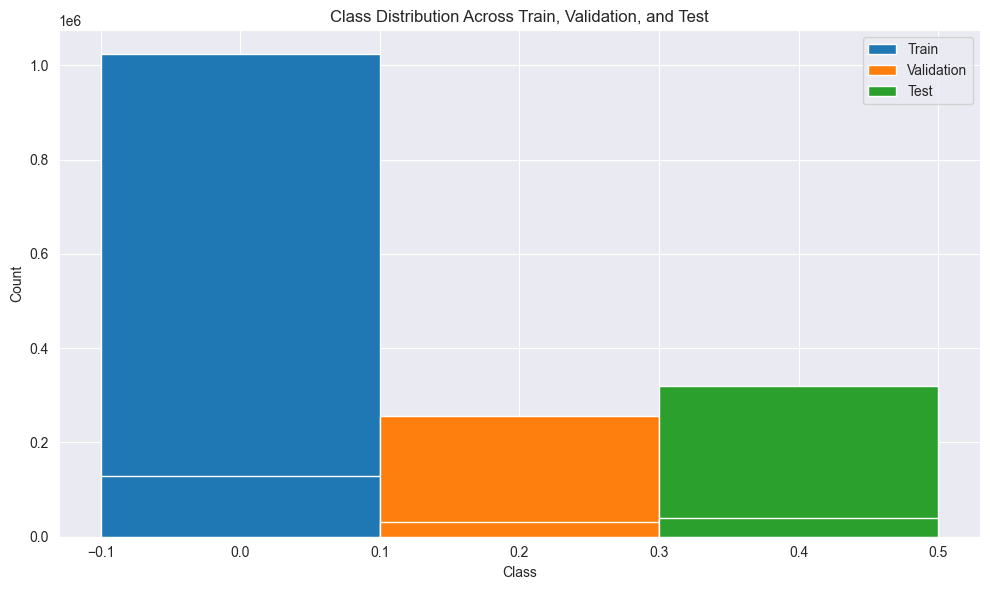

In [6]:
datasets_labels = ['Train', 'Validation', 'Test']
distributions = [
    np.bincount(y_train),
    np.bincount(y_val),
    np.bincount(y_test)
]

bar_width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

for i, dist in enumerate(distributions):
    ax.bar(
        i * bar_width, dist, bar_width, label=datasets_labels[i]
    )

ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Class Distribution Across Train, Validation, and Test')
ax.legend()

plt.tight_layout()
plt.show()


Разбиение на train и test выборки по Out-Of-Time (OOT) 

In [7]:
split_date = "2017-04-01"

train_data = df[df['created_date'] < split_date]
test_data = df[df['created_date'] >= split_date]

Для разбиения на train и val выборки будем использовать In-Sample

In [8]:
X = train_data['ctws']
y = train_data['toxicity_b']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [9]:
# Test данные
X_test = test_data['ctws']
y_test = test_data['toxicity_b']

In [10]:
# Функция обучения модели и предсказания и визуализации результатов
def train_and_predict_toxicity(model, X_train, X_test, y_train):
    #Обучение модели
    model.fit(X_train, y_train)

    # Предсказание классов
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Предсказание вероятностей классов (если доступно)
    if hasattr(model, 'predict_proba'):
        # Вероятности для положительного класса
        y_pred_proba_train = model.predict_proba(X_train)[:, 1]
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba_train = None
        y_pred_proba_test = None

    return y_pred_train, y_pred_test, y_pred_proba_train, y_pred_proba_test


# Функция для отображения метрик
def show_metrics(y_train, y_test, y_pred_train, y_pred_test, y_pred_proba_train, y_pred_proba_test, title):
    # Вычисляем точность (precision) — доля истинных положительных среди всех предсказанных положительных
    # одна из метрик, оценивающих качество решения задачи бинарной классификации в машинном обучении. 
    # Она давно себя зарекомендовала: это одно интерпретируемое и легко вычисляемое число, оценивающее качество алгоритма
    precision_train = precision_score(y_train, y_pred_train)
    precision_test = precision_score(y_test, y_pred_test)

    # Вычисляем полноту (recall) — доля истинных положительных среди всех фактических положительных
    recall_train = recall_score(y_train, y_pred_train)
    recall_test = recall_score(y_test, y_pred_test)

    # Вычисляем F1-метрику — гармоническое среднее между точностью и полнотой
    f1_train = f1_score(y_train, y_pred_train)
    f1_test = f1_score(y_test, y_pred_test)

    # посчитать MSE, MAE, RMSE

    # Вычисляем среднеквадратичную ошибку (MSE) — среднее значение квадратов разностей между фактическими и предсказанными значениями
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    # Вычисляем среднюю абсолютную ошибку (MAE) — среднее значение абсолютных разностей между фактическими и предсказанными значениями
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    # Вычисляем квадратный корень из MSE (RMSE) — интерпретация MSE в тех же единицах, что и данные
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)


    print(title + '\n')

    print('Precision\t\tRecall\t\t\tF1\n')
    print(f'Train: {precision_train:.2f}\t\tTrain: {recall_train:.2f}\t\tTrain: {f1_train:.2f}')
    print(f'Test: {precision_test:.2f}\t\tTest: {recall_test:.2f}\t\tTest: {f1_test:.2f}')


    # Выводим таблицу с метриками MSE, MAE и RMSE
    print('\nMSE\t\t\tMAE\t\t\tRMSE\n')
    print(f'Train: {mse_train:.2f}\tTrain: {mae_train:.2f}\tTrain: {rmse_train:.2f}')
    print(f'Test: {mse_test:.2f}\tTest: {mae_test:.2f}\tTest: {rmse_test:.2f}')

    def show_confusion_matrix(y_true, y_pred, sample_name, ax):
        # Вычисляем матрицу ошибок (confusion matrix) с нормализацией по всем элементам
        # Это показывает пропорции вместо абсолютных значений
        cm = confusion_matrix(y_true, y_pred, normalize='all')

        # Определяем метки классов для отображения в матрице
        labels = ['Non-Toxic (0)', 'Toxic (1)']
        # Преобразуем матрицу ошибок в DataFrame для удобной визуализации
        cm_df = pd.DataFrame(cm, index=labels, columns=labels)

        # Создаем тепловую карту (heatmap) на основе матрицы ошибок    
        sns.heatmap(cm_df, annot=True, fmt=".2%", cmap='twilight_shifted', ax=ax)
        ax.set_title(f'Confusion matrix ({sample_name})')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')

    def show_roc_curve(y_true, y_pred_proba, model_name, sample_name, ax):
        # Вычисляем значения FPR (False Positive Rate) и TPR (True Positive Rate)
        # на различных порогах классификации
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        # Вычисляем площадь под кривой (AUC, Area Under Curve)
        auc = roc_auc_score(y_true, y_pred_proba)

        # Строим ROC-кривую, отображая FPR по оси X, а TPR по оси Y
        ax.plot(fpr, tpr)
        # Добавляем диагональную линию (y = x) для ориентира (случайная модель)
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title(f'{model_name} ({sample_name}) ROC (AUC = {auc:.2f})')
        # Включаем сетку для удобства чтения графика
        ax.grid(True)

    # Строит кривую Precision-Recall (точность-полнота).
    def show_pr_curve(y_true, y_pred_proba, model_name, sample_name, ax):
        # Вычисляем значения precision (точности) и recall (полноты) для различных порогов
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
        # Вычисляем площадь под кривой Precision-Recall (AUC-PR)
        auc_pr = auc(recall, precision)

        # Строим график кривой Precision-Recall
        ax.plot(recall, precision)
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title(f'{model_name} ({sample_name}) Precision-Recall Curve (AUC = {auc_pr:.2f})')
        ax.grid(True)

    # Проверяем, есть ли предсказания вероятностей для тренировочной и тестовой выборок
    if y_pred_proba_train is not None and y_pred_proba_test is not None:
        _, axs = plt.subplots(3, 2, figsize=(16, 18))

        # Показываем матрицу ошибок для тренировочной и тестовой выборок
        show_confusion_matrix(y_train, y_pred_train, 'Train', axs[0, 0])
        show_confusion_matrix(y_test, y_pred_test, 'Test', axs[0, 1])

        # Показываем ROC-кривые для тренировочной и тестовой выборок
        show_roc_curve(y_train, y_pred_proba_train, title, 'Train', axs[1, 0])
        show_roc_curve(y_test, y_pred_proba_test, title, 'Test', axs[1, 1])

        # Показываем кривые Precision-Recall для тренировочной и тестовой выборок
        show_pr_curve(y_train, y_pred_proba_train, title, 'Train', axs[2, 0])
        show_pr_curve(y_test, y_pred_proba_test, title, 'Test', axs[2, 1])
    else:
        # Если предсказаний вероятностей нет, создаем сетку из 1 строки и 2 столбцов (2 графика)
        _, axs = plt.subplots(1, 2, figsize=(14, 6))

        show_confusion_matrix(y_train, y_pred_train, 'Train', axs[0])
        show_confusion_matrix(y_test, y_pred_test, 'Test', axs[1])

    plt.tight_layout()
    plt.show()


# Функция получения мешка слов
def get_bows(X_train, X_test):
    vectorizer = CountVectorizer()
    return vectorizer.fit_transform(X_train), vectorizer.transform(X_test)


# Векторизация  TF-IDF
def get_tfidf(X_train, X_test):
    vectorizer = TfidfVectorizer()
    return vectorizer.fit_transform(X_train), vectorizer.transform(X_test)

Настраиваем Boosting для устранения смещения

In [11]:
def make_boosting_with_report(X_train, X_test, y_train, y_test):
    # Обучение модели
    model = XGBClassifier(
        n_estimators=100,   # Количество деревьев (итераций бустинга)
        max_depth=5,        # Максимальная глубина деревьев
        learning_rate=0.1,  # Скорость обучения
        n_jobs=2            # Количество потоков
    )
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    sample = X_test.iloc[[0]]
    print(f"Features: {sample}")
    print(f"Predicted Class: {model.predict(sample)[0]}")
    print(f"Predicted Probability: {model.predict_proba(sample)[0]}")


# Обучение с мешком слов

In [12]:
X_train_bow, X_test_bow = get_bows(X_train, X_test)

### Логистическая регрессия

In [17]:
(
    y_log_reg_bow_pred_train,
    y_log_reg_bow_pred_test,
    y_log_reg_bow_pred_proba_train,
    y_log_reg_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=LogisticRegression(max_iter=1000),
    X_train=X_train_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

LogisticRegression BoW

Precision		Recall			F1

Train: 0.83		Train: 0.55		Train: 0.66
Test: 0.73		Test: 0.48		Test: 0.58

MSE			MAE			RMSE

Train: 0.06	Train: 0.06	Train: 0.25
Test: 0.08	Test: 0.08	Test: 0.28


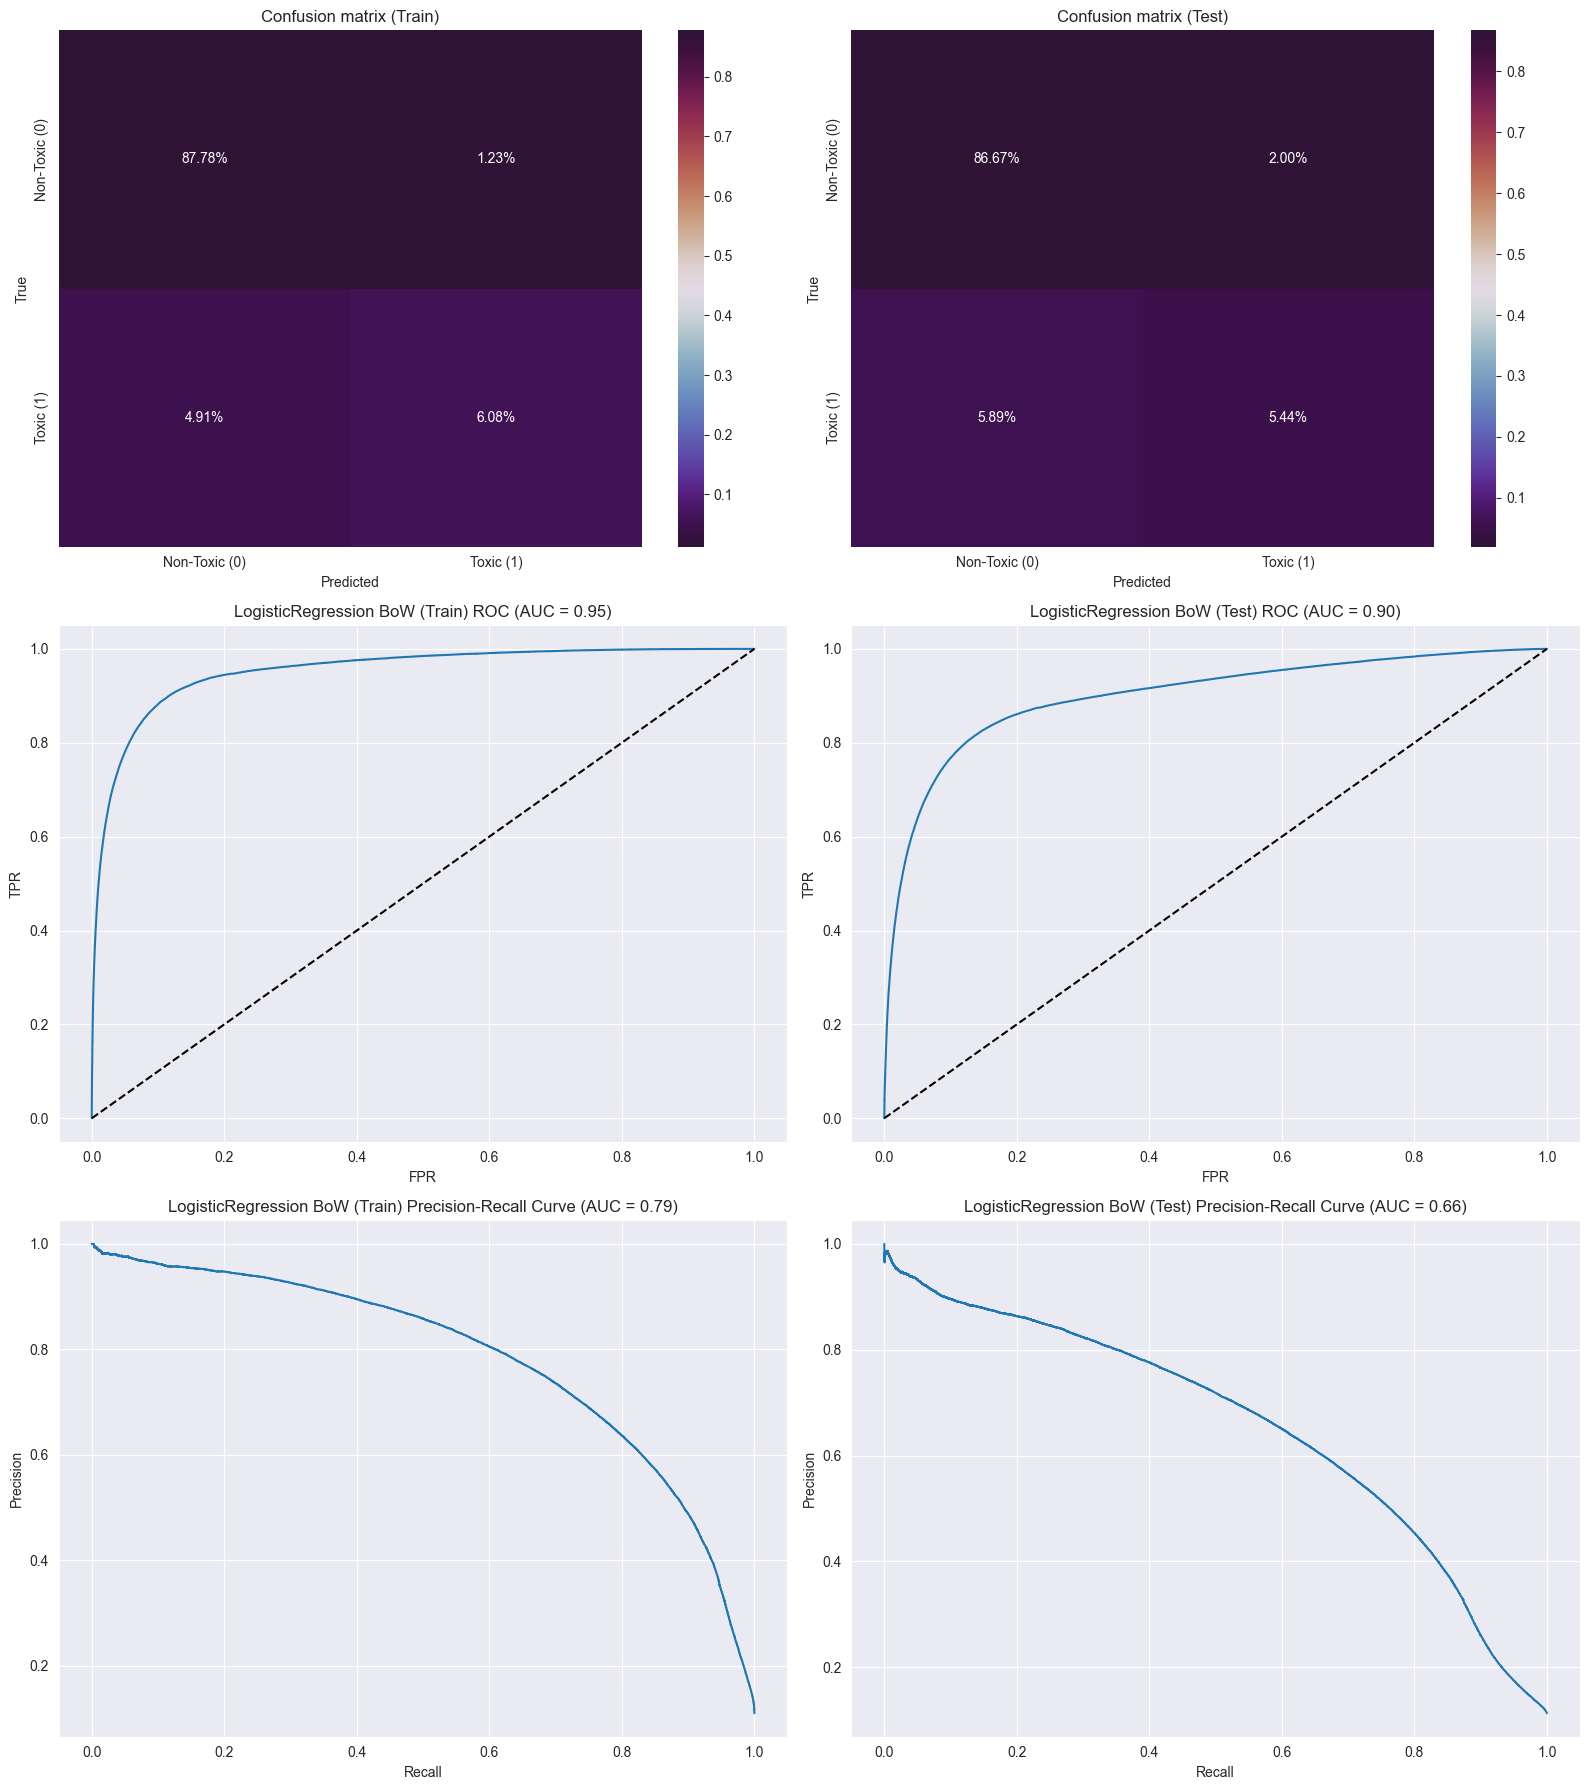

In [19]:
show_metrics(
    y_train=y_train,
    y_test=y_test,
    y_pred_train=y_log_reg_bow_pred_train,
    y_pred_test=y_log_reg_bow_pred_test,
    y_pred_proba_train=y_log_reg_bow_pred_proba_train,
    y_pred_proba_test=y_log_reg_bow_pred_proba_test,
    title='LogisticRegression BoW'
)

### SVM - используем SVC

In [ ]:
(
    y_linear_svc_bow_pred_train,
    y_linear_svc_bow_pred_test,
    y_linear_svc_bow_pred_proba_train,
    y_linear_svc_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=SVC(kernel='linear', probability=True, C=1.0),
    X_train=X_train_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

SVM BoW

Precision		Recall			F1

Train: 0.88		Train: 0.65		Train: 0.75
Test: 0.68		Test: 0.49		Test: 0.57

MSE			MAE			RMSE

Train: 0.05	Train: 0.05	Train: 0.22
Test: 0.08	Test: 0.08	Test: 0.29


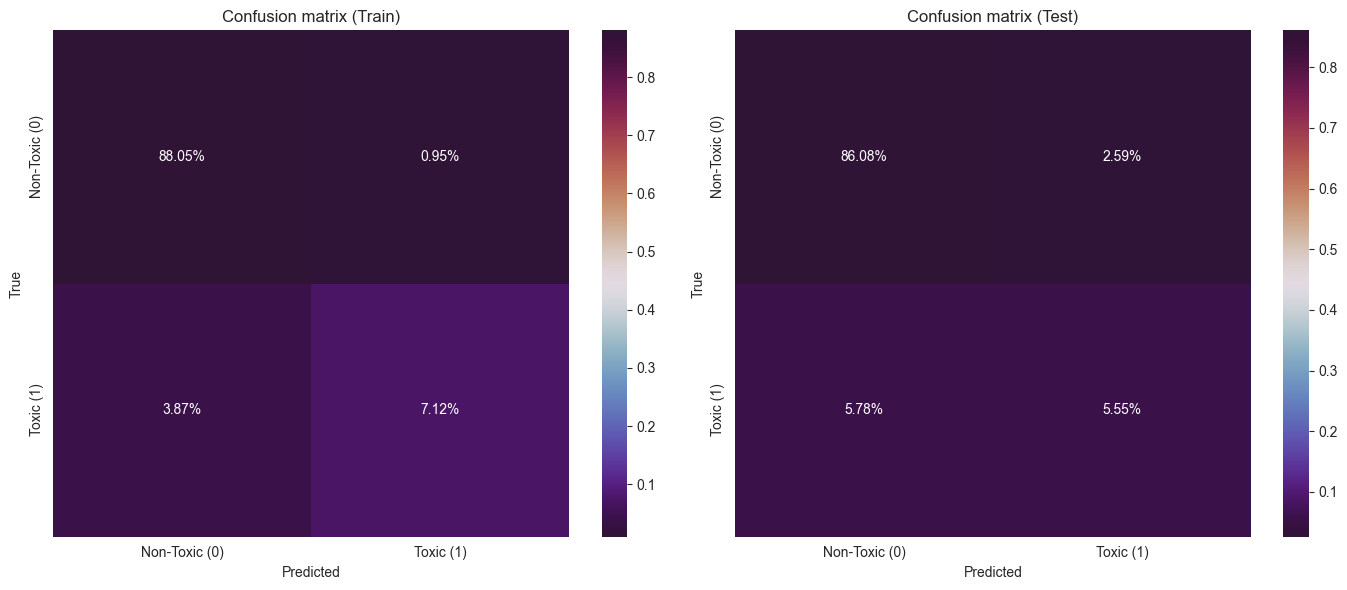

In [15]:
show_metrics(
    y_train=y_train,
    y_test=y_test,
    y_pred_train=y_linear_svc_bow_pred_train,
    y_pred_test=y_linear_svc_bow_pred_test,
    y_pred_proba_train=y_linear_svc_bow_pred_proba_train,
    y_pred_proba_test=y_linear_svc_bow_pred_proba_test,
    title='SVM BoW'
)

Применяем Boosting для устранения смещения

In [14]:
make_boosting_with_report(X_train_bow, X_test_bow, y_train, y_test)

Accuracy: 0.9069503290539833
AUC-ROC: 0.8596820014050711

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95    905556
           1       0.85      0.22      0.35    115705

    accuracy                           0.91   1021261
   macro avg       0.88      0.61      0.65   1021261
weighted avg       0.90      0.91      0.88   1021261



AttributeError: 'csr_matrix' object has no attribute 'iloc'

### Наивный Байес (Наивный байесовский классификатор)

In [22]:
(
    y_nb_bow_pred_train,
    y_nb_bow_pred_test,
    y_nb_bow_pred_proba_train,
    y_nb_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=MultinomialNB(),
    X_train=X_train_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

In [ ]:
show_metrics(
    y_train=y_train,
    y_test=y_test,
    y_pred_train=y_nb_bow_pred_train,
    y_pred_test=y_nb_bow_pred_test,
    y_pred_proba_train=y_nb_bow_pred_proba_train,
    y_pred_proba_test=y_nb_bow_pred_proba_test,
    title='MultinomialNB BoW'
)

# Обучение с TF-IDF

In [16]:
X_train_tfidf, X_test_tfidf = get_tfidf(X_train, X_test)

### Логистическая регрессия

In [18]:
(
    y_log_reg_tfidf_pred_train,
    y_log_reg_tfidf_pred_test,
    y_log_reg_tfidf_pred_proba_train,
    y_log_reg_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=LogisticRegression(max_iter=1000),
    X_train=X_train_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

LogisticRegression TF-IDF

Precision		Recall			F1

Train: 0.80		Train: 0.47		Train: 0.60
Test: 0.79		Test: 0.46		Test: 0.58

MSE			MAE			RMSE

Train: 0.07	Train: 0.07	Train: 0.27
Test: 0.08	Test: 0.08	Test: 0.27


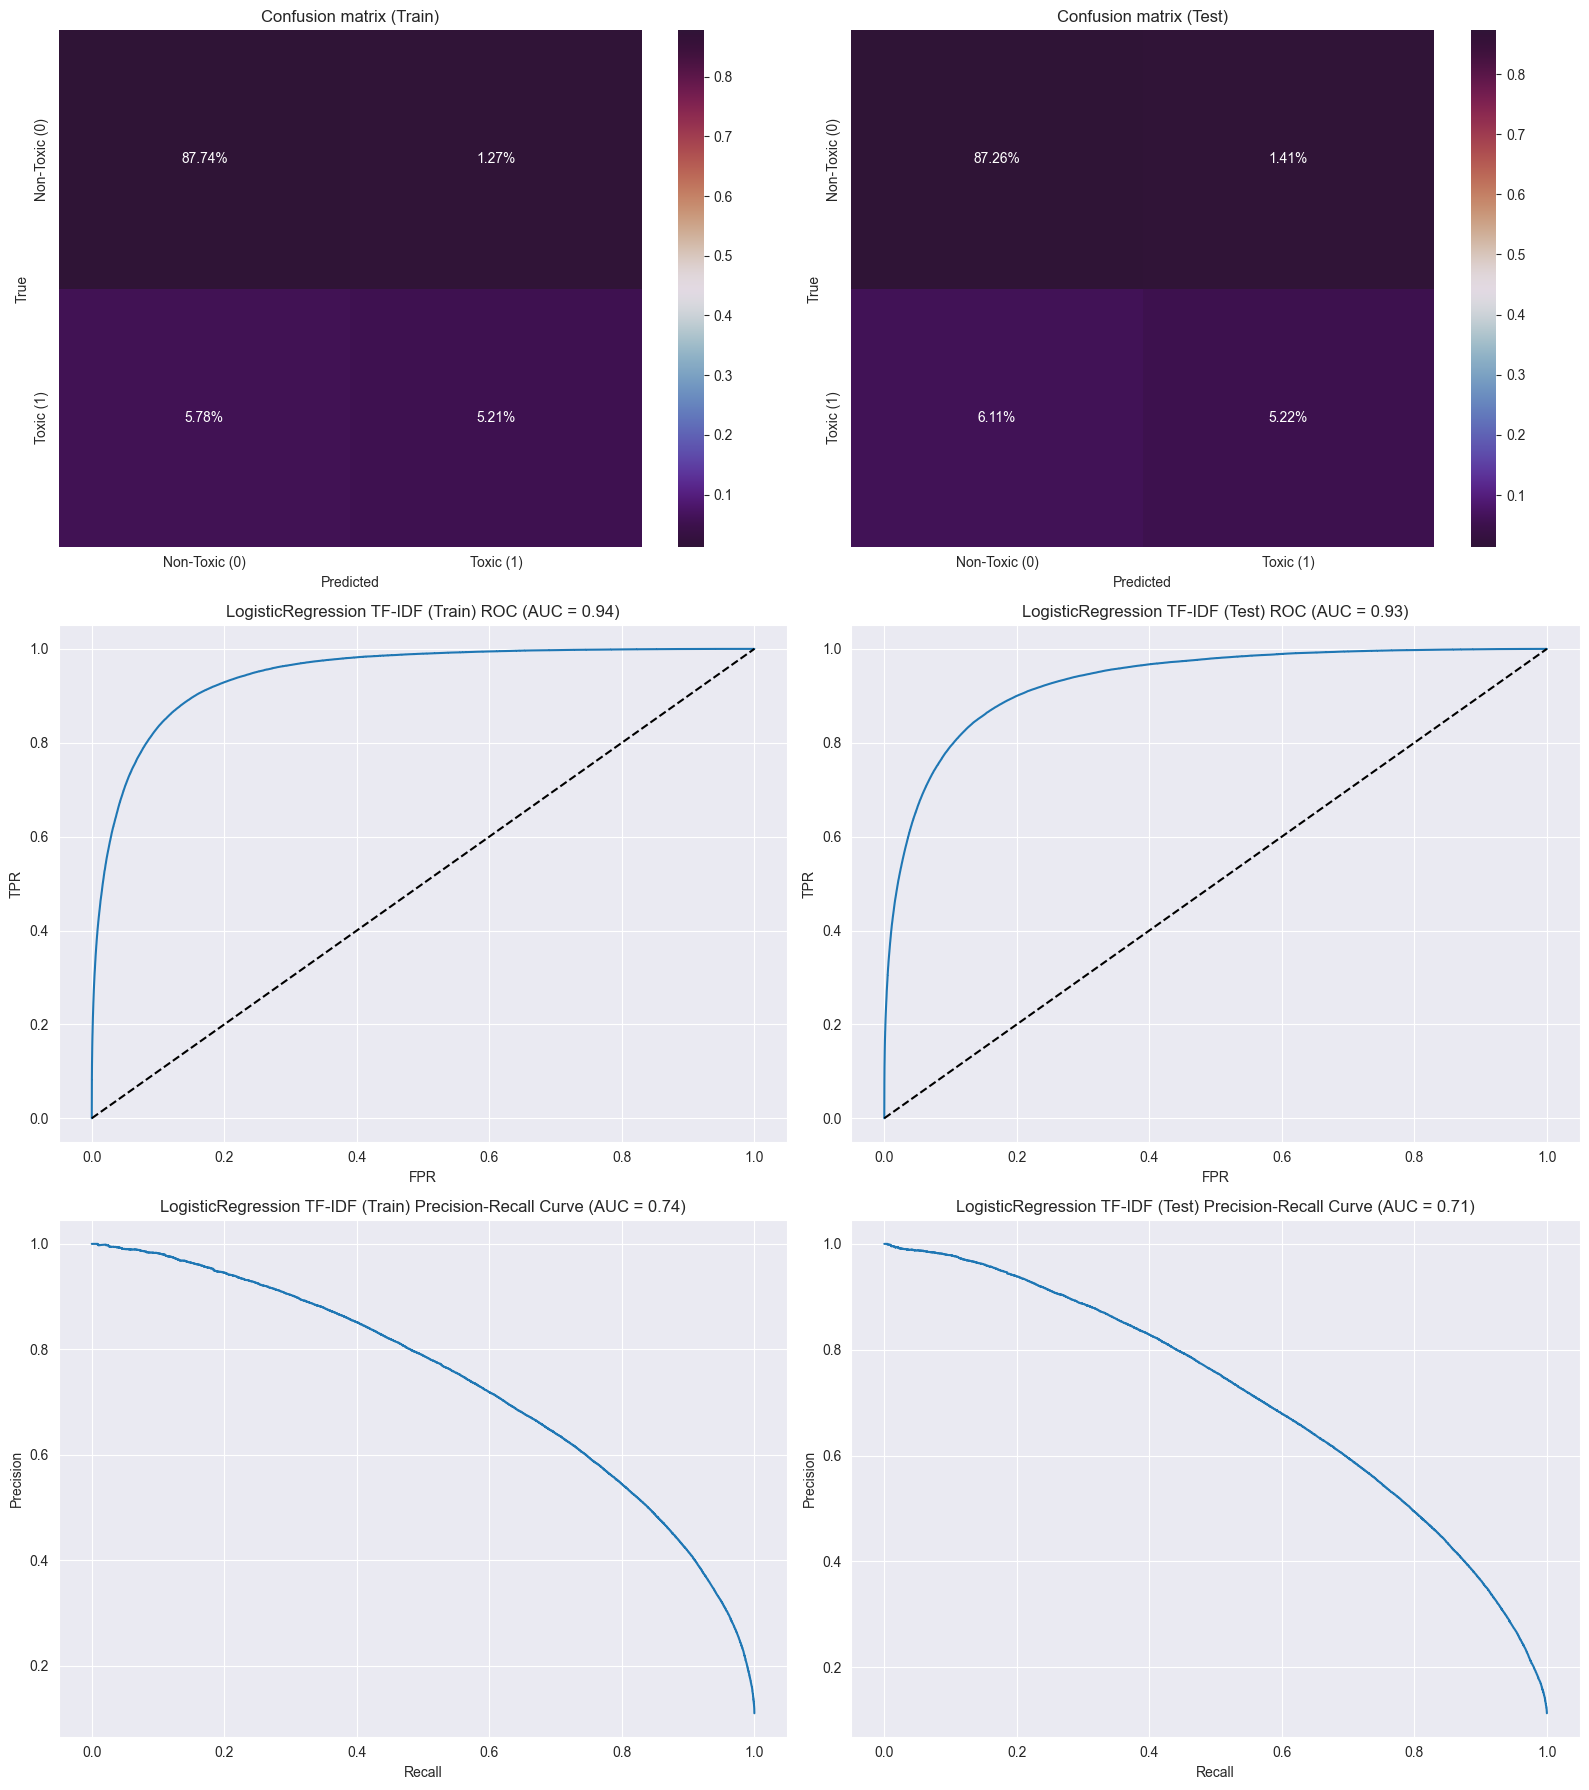

In [21]:
show_metrics(
    y_train=y_train,
    y_test=y_test,
    y_pred_train=y_log_reg_tfidf_pred_train,
    y_pred_test=y_log_reg_tfidf_pred_test,
    y_pred_proba_train=y_log_reg_tfidf_pred_proba_train,
    y_pred_proba_test=y_log_reg_tfidf_pred_proba_test,
    title='LogisticRegression TF-IDF'
)

### SVM

In [ ]:
(
    y_linear_svc_tfidf_pred_train,
    y_linear_svc_tfidf_pred_test,
    y_linear_svc_tfidf_pred_proba_train,
    y_linear_svc_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=SVC(kernel='linear', probability=True, C=1.0),
    X_train=X_train_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

In [ ]:
show_metrics(
    y_train=y_train,
    y_test=y_test,
    y_pred_train=y_linear_svc_tfidf_pred_train,
    y_pred_test=y_linear_svc_tfidf_pred_test,
    y_pred_proba_train=y_linear_svc_tfidf_pred_proba_train,
    y_pred_proba_test=y_linear_svc_tfidf_pred_proba_test,
    title='SVM TF-IDF'
)

### Наивный Байес (Наивный байесовский классификатор)

In [ ]:
(
    y_nb_tfidf_pred_train,
    y_nb_tfidf_pred_test,
    y_nb_tfidf_pred_proba_train,
    y_nb_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=MultinomialNB(),
    X_train=X_train_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

In [ ]:
show_metrics(
    y_train=y_train,
    y_test=y_test,
    y_pred_train=y_nb_tfidf_pred_train,
    y_pred_test=y_nb_tfidf_pred_test,
    y_pred_proba_train=y_nb_tfidf_pred_proba_train,
    y_pred_proba_test=y_nb_tfidf_pred_proba_test,
    title='MultinomialNB TF-IDF'
)